## 문제 사항
* 가끔 인식 부정확 - save_img/*_difficult.* 참조 - 거리 threshold 늘려서 다소 개선, 해결은 안됨
* 가운데 구획 필요할 수 있음 - 대응 전략

* 오른 쪽 view 자꾸 겨드랑이로 - 자세 약간 수정함, 너무 돌지 않도록 수정 v
* 툴 형상 변경 - 깊이 5cm 정도만 줄이자 에 따라 데이터 다시 수집 필요 v
* 작업 너비 너무 좁음 - 더 확실한 영역 데이터셋 준비 필요 v
* 동작 비효율적 - 일단 sweep은 task space 경로로 v
* 반대편 이동 정상 동작 안됨 - 해결 v
* 이동 후 오프셋에 따라 동작 불가능해지는 상황 발생 - 미묘한 싱귤러리티 등이 원인 - 오프셋에 따른 보정 전략 도입 v
* 깊이 방향도 데이터 기반으로 실제 섹션 반영 / 랜덤노이즈 테스트 v
* 3 칸 이상 나누기 v
* multiprocess lock 문제 ?


In [1]:
import os
import sys
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *


CONNECT_CAM = False
ENABLE_DETECT = True
CONNECT_INDY = False
CONNECT_MOBILE = False

ip_cur =  get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.4
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


## Set table dimension

In [2]:
# Table dimension
T_Width = 1.8
T_Height = 0.785
T_Depth = 0.734
TOOL_DIM = [0.32, 0.08]
ROBOT_Z_ANGLE = np.pi
MARGIN = 0
TRACK_THICKNESS = 0.001

## Prepare robot and pipeline setting

In [3]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)

robot_config = RobotConfig(0, RobotType.indy7, None, INDY_IP, specs={"no_sdk":True})
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[robot_config]
              , connection_list=[CONNECT_INDY])

s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,ROBOT_Z_ANGLE))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary( -1.5, 1.5, -1, 1, -0.1, 1.75)

add_env(gscene)
viewpoint = add_cam(gscene, tool_link="indy0_tcp")
add_indy_tool_kiro(gscene, tool_link="indy0_tcp", face_name="brush_face", zoff=-0.04)

from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)
BASE_LINK = "base_link"
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

# Register binders
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
brush_face = pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepFramer, point=(-gscene.NAME_DICT['brush_face'].dims[0]/2,0,0), 
                     rpy=(0,np.pi/2*1,0))

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
from pkg.planning.filtering.task_clearance_filter import TaskClearanceChecker

# gcheck = GraspChecker(pscene)
# rcheck = ReachChecker(pscene)
# tcheck = TaskClearanceChecker(pscene, gcheck)
# checkers_all = [tcheck, rcheck, gcheck]
# # lcheck = LatticedChecker(pscene, gcheck)
# # checkers_all.append(lcheck)

# mplan.motion_filters = checkers_all

indy = crob.robot_dict["indy0"]
# if CONNECT_INDY:
#     with indy:
#         indy.reset_robot()

connection command:
indy0: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


## move indy to viewing pose

In [4]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(Qcur)

## Attach to detection server

In [5]:
if ENABLE_DETECT:
    attacth_to_server()

## Get image

2.466012097331539
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.556113e-03, and correspondence_set size of 25061
Access transformation to get result.
Transformation is:
[[ 0.88269948 -0.00785563  0.46987223 -0.52528342]
 [ 0.18816773  0.92211639 -0.33807436 -0.23497566]
 [-0.4306211   0.38683285  0.81542984  2.35746877]
 [ 0.          0.          0.          1.        ]]


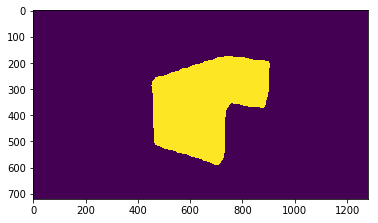

In [6]:
if CONNECT_CAM:
#     rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
else:
    cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
    d_scale = 0.0002500000118743628
    # Set color, depth image path
    
if CONNECT_CAM:
    color_img_path = SAVE_DIR + '/color.jpg'
    depth_img_path = SAVE_DIR + '/depth.png'
else:
    color_img_path = DATASET_CAM_DIR + '/color.jpg'
    depth_img_path = DATASET_CAM_DIR + '/depth.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(color_img_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(depth_img_path, flags=cv2.IMREAD_UNCHANGED)

# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)
ICP_result1 = None
if mask_out is not None:
    plt.imshow(mask_out)
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/color_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/depth_crop.png', depth_instance)
    
    set_cam_params(cam_intrins, d_scale)
    model_mesh, pcd_out = preprocessing()
    ICP_result1 = compute_ICP(model_mesh, pcd_out, (-T_Height, -T_Depth, 0.0))
    #ICP_result2 = compute_ICP(model_mesh, pcd2)
    
if ICP_result1 is None: # test
    ICP_result1 = np.array([[ 0.97952723,  0.00354742,  0.20128047, -0.63449415],
                            [ 0.08693341,  0.89435887, -0.43882204, -0.18267728],
                            [-0.18157366,  0.44733614,  0.87574048,  1.77040063],
                            [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [7]:
gscene.show_pose(VIEW_POSE)
_ =viewpoint.draw_traj_coords([VIEW_POSE])

In [8]:
TABLE_DIMS = np.array((T_Depth,T_Width,T_Height))
OFF_DIR = np.array([1,1,-1])
# OFF_DIR = np.array([1,1,0])
#TABLE_DIMS[[0,1,2]]
#np.hstack([TABLE_DIMS[[0,1]], [0]])
T_toff = SE3(Rot_axis(3,np.pi), np.divide(TABLE_DIMS[[0,1,2]]*OFF_DIR,2))
T_co = np.matmul(np.matmul(ICP_result1, SE3(Rot_axis(1, np.pi/2), [0]*3)), T_toff)
T_lo = np.matmul(viewpoint.Toff, T_co)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE, gscene.joint_names))
T_bo=np.matmul(T_bc, T_co)

# fit to plane
floor_g = gscene.NAME_DICT["floor"]
floor_height = floor_g.center[2] + floor_g.dims[2]/2

# Floor Fitting
T_bo[2,3] =  floor_height+TABLE_DIMS[2]/2

azimuth, zenith = mat2hori(T_bo[:3,:3])
zenith_up = np.pi-zenith
Raz = Rot_axis(3, azimuth)
Rzn = Rot_axis(2, -zenith_up)
Roff = np.matmul(np.matmul(Raz, Rzn), Raz.transpose())
T_bo[:3,:3] = np.matmul(Roff, T_bo[:3,:3])

gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry 추가
table_prev = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## select task area

In [9]:
TABLE_HEIGHT = floor_height + TABLE_DIMS[2]
T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
P_floor_e = T_brush_e[:3, 3] + [0, 0, TABLE_HEIGHT]
EE_DEPTH_OFF, _, EE_HEIGHT = P_floor_e
sweep_width, (area_width, area_depth), width_range, divisions, div_num, corner_center = select_task_area(
    robot_config, TABLE_DIMS, TOOL_DIM, EE_DEPTH_OFF, EE_HEIGHT, ROBOT_Z_ANGLE, 
    MARGIN=MARGIN, TOOL_DEPTH_MIN=0.6, TOOL_DEPTH_MAX=1.0)

reference height: 0.536499995947
== MOTION_DEPTH: 0.414 ==
== WIIPE_DEPTH: 0.414 ==
== MOTION_DEPTH: 0.414 ==
== WIIPE_DEPTH: 0.207 ==
sweep depths: (0.48, 0.7)
divisions: (2, 2)


# Main Loop

In [16]:
# for i_cn in range(4):
#     cn_cur = CornerSequence[i_cn]
#     if cn_cur == Corners.Right and divisions[0]<2:
#         continue
i_cn = 0

In [17]:
cn_cur = CornerSequence[i_cn]
print("== Current workspace section: {}".format(cn_cur.name))
section_size = np.concatenate([np.divide(table_prev.dims[:2],  divisions), [TRACK_THICKNESS]])
off_corner = np.divide(table_prev.dims, 2)*corner_point_dirs[cn_cur]
off_sect = (np.divide(table_prev.dims, 2) - np.divide(section_size, 2))*corner_point_dirs[cn_cur]
T_rot_table = SE3(RotationSequence[i_cn], (0,0,0))
T_tf = SE3(np.identity(3), off_sect)
T_ft = SE3_inv(T_tf)

== Current workspace section: Left


## Add table on relative target location

In [18]:
track, track_face = add_track(table_prev, TABLE_HEIGHT, area_depth, area_width, corner_center)
T_bt, T_bb2 = calc_base_target(table_prev, track, T_ft, T_rot_table)
gscene.add_highlight_axis("target", "base", "base_link", T_bb2[:3,3], T_bb2[:3,:3])
T_mm2, T_bm2 = base_offet_to_mobile(T_bb2, CONNECT_MOBILE)
gscene.add_highlight_axis("target", "mobile", "base_link", T_bm2[:3,3], T_bm2[:3,:3])

## move mobile robot

In [19]:
cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(T_mm2, CONNECT_MOBILE)
move_mobile_robot(cur_xyzw, tar_xyzw_rd, tar_xyzw, CONNECT_MOBILE,
                  move_direct=cn_cur == Corners.Right)

curre  xyzw: [0 0 0 1]
ready  xyzw: [ 2.19 -1.06  0.51  0.86]
target xyzw: [ 2.37 -0.71  0.51  0.86]
move to: [ 2.19 -1.06  0.51  0.86]
move to: [ 2.37 -0.71  0.51  0.86]


(0, 0, 0, 1)

## update table location

In [20]:
## add moved table in front of robot
table_front = gscene.create_safe(GEOTYPE.BOX, "table_front", "base_link", 
                                 dims=table_prev.dims, 
                                 center=T_bt[:3,3], 
                                 rpy=Rot2rpy(T_bt[:3,:3]),
                                 color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)

gscene.NAME_DICT["table"].color = (0.8,0.8,0.8,0.0)
gscene.update_markers_all()

# corner_center_rel = np.abs(np.subtract(tuple(corner_center)+(TABLE_HEIGHT,), table_front.center))

### calc gaze pose

In [21]:
gaze_traj, success = calc_gaze_pose(cn_cur, mplan, table_front, viewpoint, CONNECT_INDY, GAZE_DIST=0.5)
if success:
    gscene.show_motion(gaze_traj)
    gaze_pose = gaze_traj[-1]

GAZE: True


## Move to gaze pose

In [22]:
if CONNECT_INDY:
    indy.move_joint_wp(gaze_traj, None, None, None)
    
# ## return from gaze pose
# if CONNECT_INDY:
#     indy.move_joint_wp(np.array(list(reversed(gaze_traj))), None, None, None)

## Refine plane

Coeffs of eq of fitting plane are :
(0.18281672151796005, 0.6213750547573301, 0.7618865320103445, -0.4933720945112611)
0.42407640993113854
[ 0.58243268  0.42281734 -0.439     ]
[ 0.56501573  0.11673847 -0.439     ]


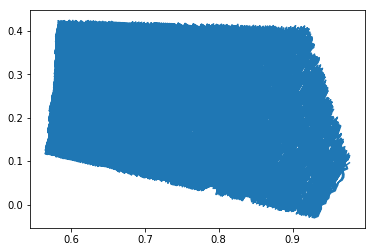

In [23]:
if CONNECT_INDY:
    with indy:
        Qcur = indy.get_qcur()
else:
    try:
        Qcur = np.load(DATASET_CAM_DIR + '/tablepose_11.npy')
    except Exception as e:
        print(e)

T_bo_bak = table_front.Toff
table_front = refine_plane(gscene, track, viewpoint, T_ft, Qcur, TABLE_DIMS, cn_cur, CAM_HOST, CONNECT_CAM, CONNECT_INDY, ENABLE_DETECT)
table_prev = table_front
T_bo = table_front.Toff

## adjust track

In [24]:
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", section_size, 
                           center = T_tf[:3,3], #corner_center_rel*corner_point_dirs[cn_cur], 
                           rpy= Rot2rpy(T_tf[:3,:3]), #Rot2rpy(corner_orientations[cn_cur]), 
                           color=(0.0,0.8,0.8,0.2), display=True, fixed=True, collision=True,
                           parent="table_front")
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.0))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

width_range_fit = (np.mean(width_range)-section_size[1]/2, np.mean(width_range)+section_size[1]/2)
sweep_list, track_list = make_work_plane(pscene, track, TOOL_DIM, fix_orientation_front=True)

# init planning

In [25]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
# initial_state = pscene.initialize_state(crob.home_pose)
initial_state = pscene.initialize_state(VIEW_POSE)
print(initial_state.node)

# # remove place points except for the current one
# use_current_place_point_only(pscene, initial_state)

(0, 0)


## search

In [26]:
from pkg.utils.traj_utils import simplify_schedule, mix_schedule
mplan.reset_log(False)
gtimer.reset()
tplan.prepare()
mplan.update_gscene()
    
print(initial_state.node)

obj_num = 0
sweep_num = len(sweep_list)
from_state = initial_state.copy(pscene)
from_state.Q = np.array([0]*6)
# from_state.Q = np.array([ 0.        , -0.48869219,  1.48352986, -0.        ,  0.99483767,
#        3.14159265])
t_exe = None
snode_schedule_all = []
for sweep_idx in range(sweep_num):
#     gcheck.put_banned = [track_list[sweep_idx][2]]
    sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
#     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
    goal_nodes = [("track_face",)*obj_num+sweep_goal]
    if sweep_idx < sweep_num-1:
        for i_s in range(obj_num):
            obj_goal = ["track_face"]*obj_num
            obj_goal[i_s] = "grip1"
            goal_nodes += [tuple(obj_goal)+sweep_goal]
    gtimer.tic("plan{}".format(sweep_idx))
    ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                  timeout_loop=20, multiprocess=False, timeout=0.5, timeout_constrained=2, 
                  add_homing=False, post_optimize=False)
    gtimer.toc("plan{}".format(sweep_idx))
    schedules = ppline.tplan.find_schedules(False)
    schedules_sorted = ppline.tplan.sort_schedule(schedules)
    snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
    if sweep_idx == 0:
        snode_start = snode_schedule[1]
        pscene.set_object_state(snode_schedule[0].state)
        trajectory, success = mplan.planner.plan_joint_motion_py(
            ROBOT_NAME, tuple(snode_start.traj[-1]), tuple(gaze_pose), timeout=1)
        if success:
            snode_start.traj = trajectory
    if sweep_idx == sweep_num-1:
        added_list = ppline.add_return_motion(snode_schedule[-1], initial_state=initial_state, timeout=0.5, try_count=2)
        snode_schedule += added_list
    snode_schedule_ori = snode_schedule
    snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
#     snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 5, 1)
#     double_sweep_motions(snode_schedule_safe)
#     snode_schedule = snode_schedule_safe
#     snode_schedule = mix_schedule(mplan, snode_schedule_safe)
    snode_schedule = snode_schedule_simple
    from_state = snode_schedule[-1].state
    snode_schedule_all.append(snode_schedule)

(0, 0)
try: 0 - (0, 0)->(1, 0)
try transition motion
transition motion tried: True
result: 0 - (0, 0)->(1, 0) = success
branching: 0->1 (0.06/20.0 s, steps/err: 41(54.3599128723 ms)/0.00142146496602)
try: 1 - (1, 0)->(2, 0)
try constrained motion
joint min
constrained motion tried: False
Motion Plan Failure
result: 1 - (1, 0)->(2, 0) = fail
try: 0 - (0, 0)->(0, 1)
try transition motion
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
branching: 0->2 (0.4/20.0 s, steps/err: 43(62.3331069946 ms)/0.00163745418395)
try: 2 - (0, 1)->(0, 2)
try constrained motion
joint max
constrained motion tried: False
Motion Plan Failure
result: 2 - (0, 1)->(0, 2) = fail
try: 2 - (0, 1)->(0, 2)
try constrained motion
joint max
constrained motion tried: False
Motion Plan Failure
result: 2 - (0, 1)->(0, 2) = fail
try: 0 - (0, 0)->(0, 1)
try transition motion
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
branching: 0->3 (0.88/20.0 s, steps/err: 38(58.1619739532 ms)/0.00

## Refine sweep motion

In [27]:
from demo_utils.refine_sweep import simplify_sweep
for snode_schedule in snode_schedule_all:
    simplify_sweep(pscene, mplan, snode_schedule, len_traj=20)

## Play plan

In [22]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.1)


(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)
(2, 0)->(2, 1)
(2, 1)->(2, 2)
(2, 2)->(2, 2)


## Execute plan

In [23]:
def fn_move_indy():
    print("execute one task")
    if CONNECT_INDY:
        for snode_schedule in snode_schedule_all:
            ppline.execute_schedule(snode_schedule, one_by_one=True)
            with indy:
                time.sleep(0.5)
                indy.wait_for_move_finish()

        with indy:
            indy.joint_move_to(np.rad2deg(VIEW_POSE))
            time.sleep(0.5)
            indy.wait_for_move_finish()

In [24]:
fn_move_indy()
if cn_cur == Corners.Left and divisions[0]>=2:
    cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(SE3(np.identity(3), [0,section_size[1], 0]), CONNECT_MOBILE)
    ref_xyzw = cur_xyzw
    delta_xyzw = np.subtract(tar_xyzw, ref_xyzw)
    for i_hori in range(1,divisions[0]-1):
        tar_xyzw = delta_xyzw*i_hori + ref_xyzw
        cur_xyzw = move_mobile_robot(cur_xyzw, tar_xyzw, tar_xyzw, CONNECT_MOBILE, move_direct=True)
        fn_move_indy()

execute one task
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.4  0.9  0.   1. ]
target xyzw: [0.  0.9 0.  1. ]


## Re-adjust location

In [30]:
# T_bb2 = np.matmul(T_bo, SE3_inv(T_bo_bak))
# gscene.add_highlight_axis("target", "base", "base_link", T_bb2[:3,3], T_bb2[:3,:3])

# T_mm2, T_bm2 = base_offet_to_mobile(T_bb2, CONNECT_MOBILE)

# cur_xyzw, tar_xyzw_rd, tar_xyzw = get_relative_mobile_command(T_mm2, CONNECT_MOBILE)
# cur_xyzw = move_mobile_robot(cur_xyzw, tar_xyzw_rd, tar_xyzw, CONNECT_MOBILE)

# T_bo = T_bo_bak
# table_front = gscene.create_safe(gtype=GEOTYPE.BOX, name="table_front", link_name="base_link",
#                                  dims=TABLE_DIMS, center=T_bo[:3, 3], rpy=Rot2rpy(T_bo[:3, :3]),
#                                  color=(0.8, 0.8, 0.8, 0.5), display=True, fixed=True, collision=False)

curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.52  0.02 -0.01  1.  ]
target xyzw: [-0.12  0.01 -0.01  1.  ]


## Test sweep manually

In [ ]:
# from pkg.utils.rotation_utils import *
# from pkg.planning.constraint.constraint_subject import SweepLineTask
# from pkg.utils.utils import list2dict

# def get_jacobian(gscene, gtem, Q):
#     Q_dict = list2dict(Q, gscene.joint_names)
#     Jac = []
#     for ij, jname in enumerate(gscene.joint_names):
#         joint = gscene.urdf_content.joint_map[jname]
#         Tj = T_xyzrpy((joint.origin.xyz, joint.origin.rpy))
#         T_link = get_tf(joint.parent, Q_dict, gscene.urdf_content)
#         T_bj = np.matmul(T_link, Tj)
#         zi = np.matmul(T_bj[:3, :3], joint.axis)
#         T_p = gtem.get_tf(Q_dict)
#         dpi = T_p[:3, 3] - T_bj[:3, 3]
#         zp = np.cross(zi, dpi)
#         Ji = np.concatenate([zp, zi])
#         Jac.append(Ji)
#     Jac = np.array(Jac).transpose()
#     return Jac

# for k, v in ppline.tplan.snode_dict.items():
#     gscene.show_motion(snode.traj)


#     SINGULARITY_CUT = 0.01
#     len_traj = 100

#     Qi = snode.traj[-1]
#     Qidict = list2dict(Qi, gscene.joint_names)
#     Ti = gtem.get_tf(Qidict)

#     dP = wp2.Toff[:3,3] - wp1.Toff[:3,3]
#     dPabs = np.linalg.norm(dP)
#     DP = dPabs / len_traj
#     DIR = np.concatenate([dP / dPabs, [0] * 3])
#     Q = Qi


#     singularity = False
#     Traj_wipe = [Qi]

#     for _ in range(len_traj):
#         Jac = get_jacobian(gscene, gtem, Q)
#         if np.min(np.abs(np.real(np.linalg.svd(Jac)[1]))) <= SINGULARITY_CUT:
#             singularity = True
#             print("singular")
# #             break
#         Jinv = np.linalg.inv(Jac)
#         dQ = np.matmul(Jinv, np.multiply(DIR, DP))
#         Q = Q + dQ
#         Traj_wipe.append(Q)
#         dlim = np.subtract(RobotSpecs.get_joint_limits(RobotType.indy7), Q[:, np.newaxis])
#         if np.any(dlim[:, 0] > 0):
#             print("min lim: {}".format(np.where(dlim[:, 0] > 0)[0]))
#             break
#         if np.any(dlim[:, 1] < 0):
#             print("max lim: {}".format(np.where(dlim[:, 1] < 0)[0]))
#             break
#     #         if not mplan.validate_trajectory([Q]):
#     #             print("col")
#     #             break
#     #         Tnew = gtem.get_tf(list2dict(Q, gscene.joint_names))
#     #         if np.abs(Ti[0,3]-Tnew[0,3])>0.01:
#     #             print("off")
#     #             break
#     gscene.show_motion(Traj_wipe)

#     Traj_wipe = np.array(Traj_wipe)

## test saved param

In [ ]:
# Tcur = get_tf(mplan.sweep_params[0], mplan.sweep_params[1], mplan.sweep_params[2], mplan.sweep_params[3])
# T_tar_tool = mplan.sweep_params[-1]

# ee_point = gscene.create_safe(GEOTYPE.SPHERE, "end_point", TIP_LINK, (0.01,)*3, 
#                               center=(0,0,0), rpy=(0,0,0), 
#                               color=(0.8,0.2,0.2,0.8), display=True, fixed=True, collision=False)

# from_Q_dict = mplan.sweep_params[1]
# from_Q = dict2list(from_Q_dict, gscene.joint_names)

# trajectory = get_sweep_traj(mplan, brush_face.geometry, np.subtract(T_tar_tool[:3,3], Tcur[:3, 3]),
#                             from_Q, DP=0.01, ERROR_CUT=0.01, SINGULARITY_CUT = 0.01, VISUALIZE=True, 
#                             VERBOSE=True)

# Tnew = get_tf(mplan.sweep_params[0], list2dict(trajectory[-1], gscene.joint_names), mplan.sweep_params[2], mplan.sweep_params[3])
# success = np.sum(np.abs(Tcur[:3,3]-Tnew[:3,3]))<1e-2